In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import curve_fit

# Data Wrangling

In [2]:
#loading the data set with fixed expiration date
df = pd.read_csv('example_smiles_20230915_history.csv')
df = df.drop_duplicates()

In [3]:
df = df.sort_values(by=['date', 'strike'])

In [4]:
dates = np.unique(df['date'])

In [5]:
df_day = df[df['date'] == '2023-06-30']

# Raw SVI Parameterization

First, we use the **curve_fit** in **scipy**. The input is a dataframe with certain **date**.

In [6]:
# curve_fit
def cf(dataframe):
    x = dataframe['strike']
    y = dataframe['implied_vol']
    S = dataframe['S0'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    def test(x, a, b, rho, m, sig):
        x1 = np.log(x / F_T)
        return a + b * (rho * (x1 - m) + np.sqrt((x1 - m) ** 2 + sig ** 2))
    s, _ = curve_fit(test, x, y ** 2 * T, maxfev = 5000)
    return s

In [7]:
# Record the 5 parameters from curve_fit. If answer is not found within maxfev, set parameters to be all zero.
cf_para = []
for date in dates:
    df_day = df[df['date'] == date]
    try:
        para = cf(df_day)
    except:
        para = [0, 0, 0, 0, 0]
    cf_para.append(para)

/Users/remineva/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
# Calculate the RMSE of implied volatility for a certain date.
def RMSE(para, date):
    a, b, rho, m, sig = para
    df_curr = df[df['date'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['S0'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = np.sqrt((a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))) / T)
    res = 0
    for i, j in zip(y, ans):
        res += (i - j) ** 2
    return np.sqrt(res / (len(y)))

In [9]:
# If we don't have parameters from curve_fit, set RMSE to be 0.06 so that the graph looks decent.
cf_RMSE = []
for date, para in zip(dates, cf_para):
    if any(para):
        try:
            curr = RMSE(para, date)
        except:
            curr = 0.06
        cf_RMSE.append(curr)
    else:
        cf_RMSE.append(0.06)

/Users/remineva/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


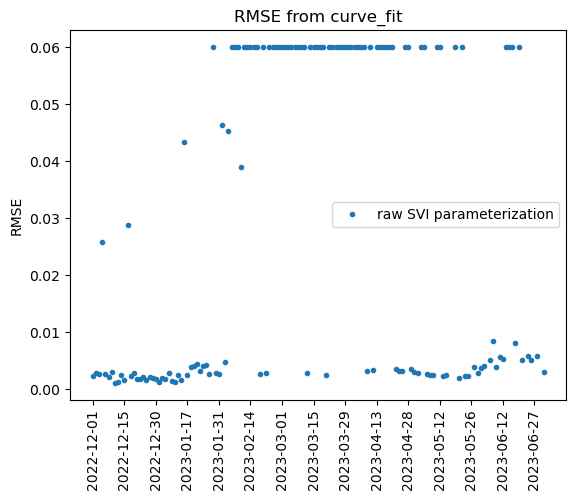

In [10]:
plt.title('RMSE from curve_fit')
plt.plot(dates, cf_RMSE, '.', label = 'raw SVI parameterization')
plt.legend()
plt.ylabel('RMSE')
plt.xticks(dates[::10], rotation='vertical');

# Quasi-Explicit Method

In [11]:
def f(para, y, v):
    a, c, d = para
    return sum((a + d * y + c * np.sqrt(y ** 2 + 1) - v) ** 2)

# quasi_explicit
def gatheral_q(para, dataframe):
    S = dataframe['S0'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x = np.log(dataframe['strike'] / F_T)
    w = T * dataframe['implied_vol'] ** 2
    m, sig = para
    y = (x - m) / sig
    cons=({'type': 'ineq', 'fun': lambda z: z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: 4 * sig - z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: z[0]},
           {'type': 'ineq', 'fun': lambda z: max(w) - z[0]})
    res = minimize(f, [0.1, 0.1, 0.1], args=(y, w), constraints = cons)
    return res.fun, res.x

def fit_q(initial, dataframe):
    m0, sig0 = initial
    m, sig = minimize(lambda x: partial(gatheral_q, dataframe=dataframe)(x)[0], [m0, sig0], method='Nelder-Mead').x
    _, para = gatheral_q((m, sig), dataframe)
    a, c, d = para
    rho = d / c
    b = c / sig
    return a, b, rho, m, sig

In [12]:
def plot_date(para, date, df):
    a, b, rho, m, sig = para
    df_curr = df[df['date'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['S0'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = np.sqrt((a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))) / T)
    plt.plot(x, y, 'x', label = 'AAPL Data')
    plt.title('AAPL 2023-09-15 Expiry Implied Volatility on ' + date)
    plt.plot(x, ans, '--', label ="Quasi-Explicit")
    plt.grid()
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.legend()

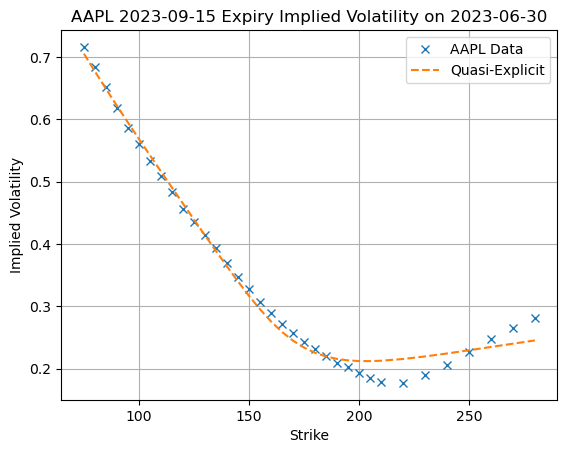

In [13]:
df_day = df[df['date'] == '2023-06-30']
para = fit_q((0.01, 0.2), df_day)
plot_date(para, '2023-06-30', df)

As we can see from the previous graph, quasi-explicit does not fit perfectly. One reason is that the bound for $a$ is too tight. We actually only need $a + dy + c\sqrt{y^2 + 1}\ge0$. i.e. $a+\sqrt{c^2-d^2}\ge0$.

In [14]:
# modified quasi_explicit
def gatheral_aux_func(para, dataframe):
    S = dataframe['S0'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x = np.log(dataframe['strike'] / F_T)
    w = T * dataframe['implied_vol'] ** 2
    m, sig = para
    y = (x - m) / sig
    cons=({'type': 'ineq', 'fun': lambda z: z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: 4 * sig - z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: z[0] + np.sqrt(abs(z[1] ** 2 - z[2] ** 2))},
           {'type': 'ineq', 'fun': lambda z: max(w) - z[0]})
    res = minimize(f, [0.1, 0.1, 0.1], args=(y, w), constraints = cons)
    return res.fun, res.x

def fit_svi(initial, dataframe):
    m0, sig0 = initial
    m, sig = minimize(lambda x: partial(gatheral_aux_func, dataframe=dataframe)(x)[0], [m0, sig0], method='Nelder-Mead').x
    _, para = gatheral_aux_func((m, sig), dataframe)
    a, c, d = para
    rho = d / c
    b = c / sig
    return a, b, rho, m, sig

In [15]:
quasimo_para = []
for date in dates:
    df_day = df[df['date'] == date]
    para = fit_svi((0, 0.2), df_day)
    quasimo_para.append(para)

In [16]:
quasimo_RMSE = []
for date, para in zip(dates, quasimo_para):
    quasimo_RMSE.append(RMSE(para, date))

In [17]:
quasi_para = []
for date in dates:
    df_day = df[df['date'] == date]
    para = fit_q((0, 0.2), df_day)
    quasi_para.append(para)

In [18]:
quasi_RMSE = []
for date, para in zip(dates, quasi_para):
    quasi_RMSE.append(RMSE(para, date))

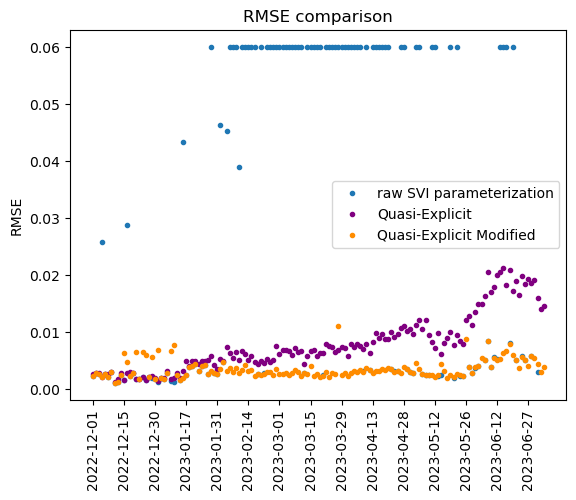

In [19]:
plt.title('RMSE comparison')
plt.plot(dates, cf_RMSE, '.', label = 'raw SVI parameterization')
plt.plot(dates, quasi_RMSE, '.', label = 'Quasi-Explicit', color = 'purple')
plt.plot(dates, quasimo_RMSE, '.', label = 'Quasi-Explicit Modified', color = 'darkorange')
plt.legend()
plt.ylabel('RMSE')
plt.xticks(dates[::10], rotation='vertical');

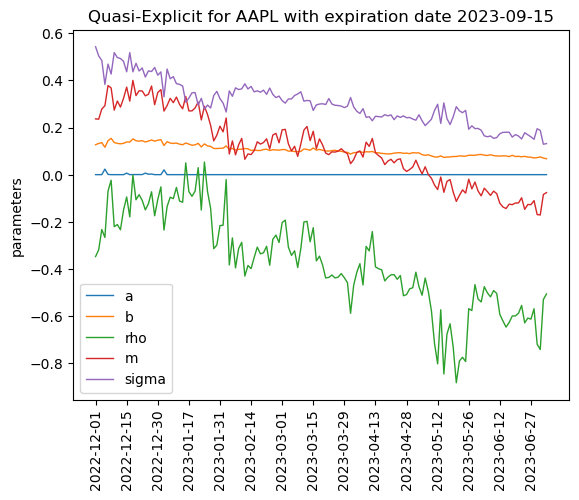

In [20]:
#parameter behavior for quasi-explicit
plt.plot(dates, quasi_para, '-', label = ['a', 'b', 'rho', 'm', 'sigma'], linewidth = 1)
plt.legend()
plt.ylabel('parameters')
plt.title('Quasi-Explicit for AAPL with expiration date 2023-09-15')
plt.xticks(dates[::10], rotation='vertical');

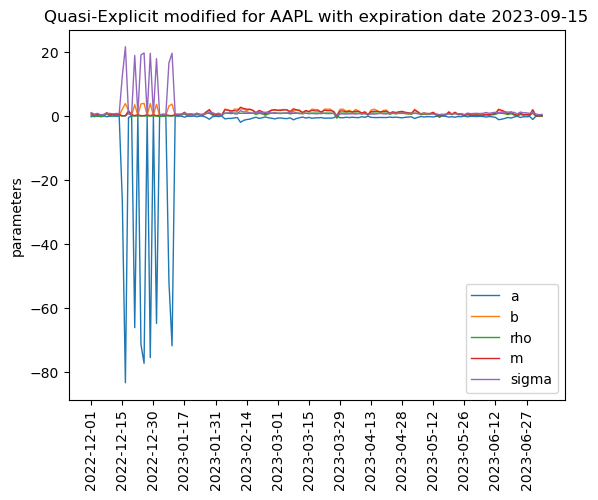

In [21]:
#parameter behavior for quasi-explicit modified
plt.plot(dates, quasimo_para, '-', label = ['a', 'b', 'rho', 'm', 'sigma'], linewidth = 1)
plt.legend()
plt.ylabel('parameters')
plt.title('Quasi-Explicit modified for AAPL with expiration date 2023-09-15')
plt.xticks(dates[::10], rotation='vertical');

The following is the density function $g$ to check butterfly arbitrage. Negative value means butterfly arbitrage existing.

In [22]:
def g(sviparams, k):
    a = sviparams['a']
    b = sviparams['b']
    sig = sviparams['sig']
    rho = sviparams['rho']
    m = sviparams['m']
    discr = np.sqrt((k - m) * (k - m) + sig * sig)
    w = a + b * (rho * (k - m) + discr)
    dw = b * rho + b * (k - m) / discr
    d2w = b * sig ** 2 / (discr * discr * discr)
    return 1 - k * dw / w + dw * dw / 4 * (-1 / w + k * k / (w * w) - 4) + d2w / 2

In [23]:
def check_butterfly(date):
    x = np.linspace(-1.5, 1.5, 500)
    a, b, rho, m, sig = fit_svi((0, 0.2), df[df['date'] == date])
    g_values = g({'a': a, 'b': b, 'sig': sig, 'rho': rho, 'm': m}, x)
    plt.plot(x, g_values, color='blue', linewidth=2)
    plt.xlabel('Log-strike k')
    plt.ylabel('g(k)')
    plt.title('Butterfly g(.) function')

Text(0.5, 1.0, 'AAPL Expired on 2023-09-15 from Quasi-Explicit Method')

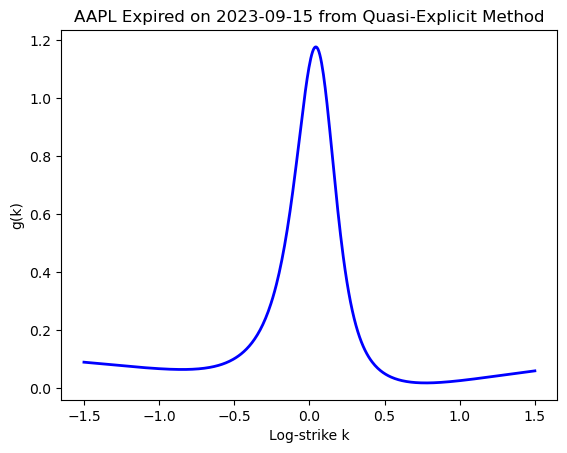

In [25]:
x = np.linspace(-1.5, 1.5, 500)
a, b, rho, m, sig = fit_svi((0, 0.2), df[df['date'] == '2023-06-30'])
g_values = g({'a': a, 'b': b, 'sig': sig, 'rho': rho, 'm': m}, x)
plt.plot(x, g_values, color='blue', linewidth=2)
plt.xlabel('Log-strike k')
plt.ylabel('g(k)')
plt.title('AAPL Expired on 2023-09-15 from Quasi-Explicit Method')